<a href="https://colab.research.google.com/github/aydanmufti/dx704-project-13/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DX 704 Week 13 Project
This week's project will build a simple agent using language models and tools.
You will integrate the Gemini language model API with custom tools that you create to assist in task automation.


The full project description and a template notebook are available on GitHub: [Project 13 Materials](https://github.com/bu-cds-dx704/dx704-project-13).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 0: Gemini Tool Example

Review the code and its output below to get an idea for how the Gemini API uses tools.

* https://ai.google.dev/gemini-api/docs/tools
* https://ai.google.dev/gemini-api/docs/function-calling

In [1]:
%pip install -q google-genai genanki

In [2]:
import hashlib

import genanki
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from google.colab import userdata

In [15]:
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [16]:
# Rate limit documentation https://ai.google.dev/gemini-api/docs/rate-limits
model_name = 'gemini-2.0-flash' #'gemini-2.0-flash'

In [17]:
change_light_array_function = {
    "name": "change_light_array",
    "description": "Change the color of a light in a 64x64 array of LEDs.",
    "parameters": {
        "type": "object",
        "properties": {
            "red": {"type": "integer", "description": "Red value of the color."},
            "green": {"type": "integer", "description": "Green value of the color."},
            "blue": {"type": "integer", "description": "Blue value of the color."},
            "x": {"type": "integer", "description": "X coordinate of the light. Must be between 0 and 63 inclusive."},
            "y": {"type": "integer", "description": "Y coordinate of the light. Must be between 0 and 63 inclusive."},
        },
        "required": ["red", "green", "blue"],
    }
}

In [18]:
light_tools = types.Tool(function_declarations=[change_light_array_function])
light_config = types.GenerateContentConfig(tools=[light_tools])

In [19]:
light_response = client.models.generate_content(
    contents="Set the light at 3,3 to be chartreuse.",
    config=light_config,
    model=model_name
)
light_response

GenerateContentResponse(
  candidates=[
    Candidate(
      avg_logprobs=-0.006611987948417664,
      content=Content(
        parts=[
          Part(
            function_call=FunctionCall(
              args=<... Max depth ...>,
              name=<... Max depth ...>
            )
          ),
        ],
        role='model'
      ),
      finish_reason=<FinishReason.STOP: 'STOP'>
    ),
  ],
  model_version='gemini-2.0-flash',
  response_id='o9EpaZnxJ-KvjuMP-fTkwQg',
  sdk_http_response=HttpResponse(
    headers=<dict len=10>
  ),
  usage_metadata=GenerateContentResponseUsageMetadata(
    candidates_token_count=15,
    candidates_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.TEXT: 'TEXT'>,
        token_count=15
      ),
    ],
    prompt_token_count=102,
    prompt_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.TEXT: 'TEXT'>,
        token_count=102
      ),
    ],
    total_token_count=117
  )
)

In [20]:
light_response.candidates[0].content.parts[0].function_call

FunctionCall(
  args={
    'blue': 0,
    'green': 255,
    'red': 127,
    'x': 3,
    'y': 3
  },
  name='change_light_array'
)

## Part 1: Implement Agent Logging

The Agent class below uses the Gemini API's tool support to provide a chat interface that can use tools.
Modify the Agent class to save a transcript with the name AGENT_NAME.txt where AGENT_NAME is the name used when creating the Agent object.
Anything in the `contents` list inside the `run` method should be saved to that file.
Test your code with the `plain_agent` setup below.

In [27]:
class Agent(object):
    def __init__(self, name, introduction, prompt, model="gemini-2.5-flash"):
        self.name = name
        self.introduction = introduction
        self.prompt = prompt
        self.model = model

        self.function_declarations = {}
        self.functions = {}

    def predict(self, contents, **kwargs):
        kwargs.setdefault('model', self.model)

        return client.models.generate_content(contents=contents, **kwargs)

    def register_tool(self, function, **function_declaration):
        if "name" not in function_declaration:
            function_declaration["name"] = function.__name__

        function_name = function_declaration["name"]
        assert "description" in function_declaration
        assert "parameters" in function_declaration

        self.function_declarations[function_name] = function_declaration
        self.functions[function_name] = function

    def run(self):
        print("RUNNING WITH TOOLS", list(self.functions.keys()))
        tools = types.Tool(function_declarations=list(self.function_declarations.values()))
        config = types.GenerateContentConfig(tools=[tools])

        print(self.introduction, "\n\n")

        contents = []
        while True:
            p = input("> ")
            if p.strip().lower() in ("stop", "quit", "exit"):
                break

            contents.append(p)
            response = self.predict(
                contents=contents,
                config=config
            )

            for new_content_part in response.candidates[0].content.parts:
                if new_content_part.text:
                    print("TEXT", new_content_part.text)
                    contents.append(new_content_part.text)
                elif new_content_part.function_call:
                    call = new_content_part.function_call
                    print("FUNCTION CALL", call)
                    if call.name in self.functions:
                        output = self.functions[call.name](**call.args)
                        if output:
                            print("OUTPUT", output)
                            contents.append(output)
                    else:
                        print("UNRECOGNIZED FUNCTION", call.name)
                else:
                    print("UNKNOWN", new_content_part)

        # YOUR CHANGES HERE
        transcript_filename = f"{self.name}.txt"
        with open(transcript_filename, 'w') as f:
            for content in contents:
                f.write(content + '\n')


In [28]:
plain_agent = Agent(name="plain",
                    introduction="Hi, I am PlainGPT and I have no tools.",
                    prompt="You are a helpful agent that is eager to help but you have no tools.",
                    model="gemini-2.5-flash")

In [29]:
plain_agent.run()

RUNNING WITH TOOLS []
Hi, I am PlainGPT and I have no tools. 


> heyyyyyyyyyyy
TEXT Hey there! 👋 What's up?
> nothin just seeing if you work in my assignment!
TEXT Hey there! 👋

Absolutely! I can definitely help you **with** your assignment. While I can't *do* the assignment for you directly (the learning and original work are all yours!), I can assist with a whole range of things:

*   **Explaining concepts:** If there's something you don't understand.
*   **Brainstorming ideas:** Helping you come up with angles or arguments.
*   **Outlining your structure:** Organizing your thoughts.
*   **Providing examples:** To illustrate points.
*   **Reviewing your writing:** For clarity, grammar, style, and flow.
*   **Helping you find information:** Or suggesting search terms.
*   **Answering specific questions:** About the topic or requirements.

So, tell me, what's the assignment about, and how can I best assist you with it? Let's get started!
> no I'm okay! the assignment is about building

Submit "plain.txt" in Gradescope.

## Part 2: Test the Agent Code

Use the color agent below and instruct the agent to show you the colors blue, red, and cyan.
After the agent has shown those colors, make sure to end the `run` method cleanly by telling the agent stop, quit, or exit.


You will notice that the language model's behavior is different from other language models or even normal Gemini since it is working with a restricted set of tools.
You may change the agent code if you wish (e.g. to change the model or give it more tools), but be careful not to change the information stored to the contents list and the log file.


Hint: The RGB values for blue are (0, 0, 255), the RGB values for red are (255, 0, 0) and the RGB values for cyan are (0, 255, 255).
The auto-grader will be checking for those values in your log file, so make sure that the agent shows you the right colors.
Ideally, you can get it to figure out those values on its own, but in the worst case you can tell the agent the RGB values.

In [49]:
def show_color(red, green, blue):
    plt.imshow([[[red, green, blue]]])
    plt.axis('off')
    plt.show()
    return f"Red: {red}, Green: {green}, Blue: {blue}"

color_agent = Agent(name="color",
                    introduction="Hi, I am ColorGPT and I know every color.",
                    prompt="You are a helpful agent that is eager to show off your color knowledge.",
                    model="gemini-2.5-pro")
color_agent.register_tool(show_color,
                          description="Show a color!",
                          parameters = {"type": "object",
                                         "properties": {
                                             "red": {"type": "integer", "description": "Red value of the color."},
                                             "green": {"type": "integer", "description": "Green value of the color."},
                                             "blue": {"type": "integer", "description": "Blue value of the color."}
                                         }, "required": ["red", "green", "blue"]})

RUNNING WITH TOOLS ['show_color']
Hi, I am ColorGPT and I know every color. 


> Okay we'll see about that. Show me blue, then red, then cyan, then green, then lilac, and then lavender
TEXT Of course! Here are the colors you requested:
FUNCTION CALL id=None args={'green': 0, 'blue': 255, 'red': 0} name='show_color' partial_args=None will_continue=None


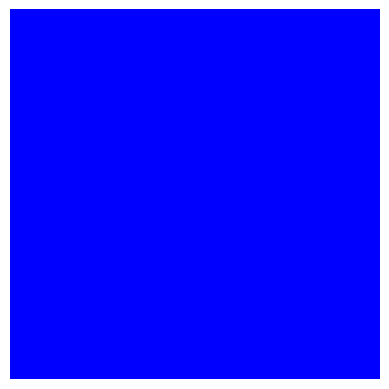

OUTPUT Red: 0, Green: 0, Blue: 255
FUNCTION CALL id=None args={'green': 0, 'blue': 0, 'red': 255} name='show_color' partial_args=None will_continue=None


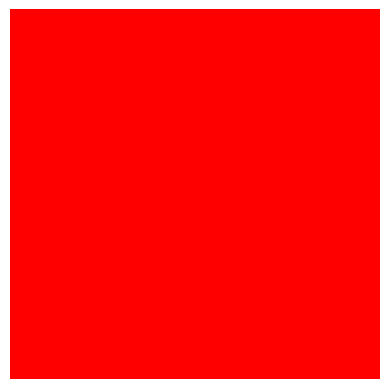

OUTPUT Red: 255, Green: 0, Blue: 0
FUNCTION CALL id=None args={'green': 255, 'blue': 255, 'red': 0} name='show_color' partial_args=None will_continue=None


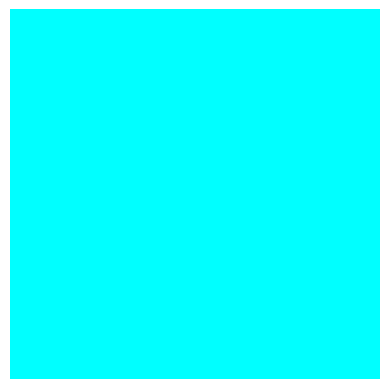

OUTPUT Red: 0, Green: 255, Blue: 255
FUNCTION CALL id=None args={'green': 255, 'blue': 0, 'red': 0} name='show_color' partial_args=None will_continue=None


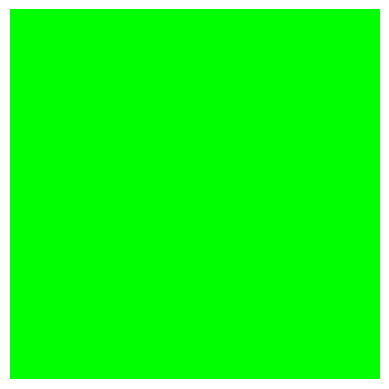

OUTPUT Red: 0, Green: 255, Blue: 0
FUNCTION CALL id=None args={'green': 162, 'red': 200, 'blue': 200} name='show_color' partial_args=None will_continue=None


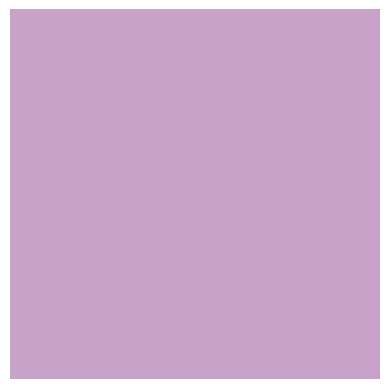

OUTPUT Red: 200, Green: 162, Blue: 200
FUNCTION CALL id=None args={'green': 230, 'red': 230, 'blue': 250} name='show_color' partial_args=None will_continue=None


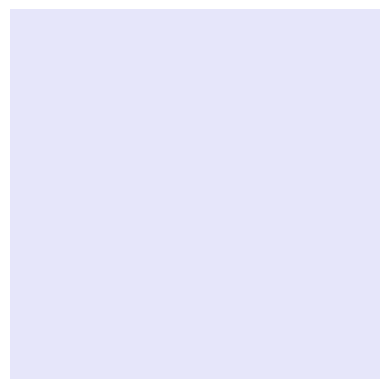

OUTPUT Red: 230, Green: 230, Blue: 250
> exit


In [52]:
color_agent.run()

Submit "color.txt" in Gradescope.

## Part 3: Modify Anki Flashcard Agent

[Anki](https://apps.ankiweb.net/) is a program to help memorization using Flashcards.
(Professor Considine uses Anki to learn foreign language vocabulary.)
The agent that follows can create an Anki "deck" and add notes to create flashcards.
However, the save functionality has not yet been integrated as a tool for the agent.
Implement that functionality and then test it by instructing the agent to save an empty deck as "empty.apkg".

In [38]:
# Simple Model setup from https://github.com/kerrickstaley/genanki?tab=readme-ov-file#models
# this defines a model of flashcards with just two fields, question for the front, and answer for the back.

simple_model = genanki.Model(
    1607392319,
    'Simple Model',
    fields=[
        {'name': 'Question'},
        {'name': 'Answer'},
    ],
    templates=[
        {
        'name': 'Card 1',
        'qfmt': '{{Question}}',
        'afmt': '{{FrontSide}}<hr id="answer">{{Answer}}',
        },
    ])

In [39]:
anki_decks = {}

In [40]:
def get_deck(deck_name):
    if deck_name not in anki_decks:
        hash = hashlib.sha256(deck_name.encode('utf-8')).hexdigest()
        hash = hash[:12]
        hash = int(hash, 16)
        anki_decks[deck_name] = genanki.deck.Deck(deck_id=hash, name=deck_name)
        anki_decks[deck_name].add_model(simple_model)

    return anki_decks[deck_name]

get_deck("test")

In [41]:
anki_agent = Agent(name="anki",
                   introduction="Hi, I am AnkiGPT and I can help you build Anki flashcard decks.",
                   prompt="You are a helpful AI that helps lookup content for flashcards and then makes the flashcards.")

In [42]:
def create_anki_note(front, back, deck):
    get_deck(deck).add_note(genanki.Note(model=simple_model, fields=[front, back]))
    return f"Created note in Anki deck {deck!r}"

anki_agent.register_tool(create_anki_note,
    description="Create a note in an Anki flashcard deck.",
    parameters= {
        "type": "object",
        "properties": {
            "front": {"type": "string", "description": "Content for front side of flash card."},
            "back": {"type": "string", "description": "Content for back side of flash card."},
            "deck": {"type": "string", "description": "Name of the Anki deck to add the note to."},
        },
        "required": ["front", "back", "deck"],
    })


In [43]:
def save_anki_deck(deck):
    genanki.Package(get_deck(deck)).write_to_file(f"{deck}.apkg")
    return f"Saved Anki deck {deck!r} to file."


In [44]:
# YOUR CHANGES HERE

anki_agent.register_tool(save_anki_deck,
    description="Save an Anki flashcard deck to a file.",
    parameters={
        "type": "object",
        "properties": {
            "deck": {"type": "string", "description": "Name of the Anki deck to save."},
        },
        "required": ["deck"],
    })

In [45]:
anki_agent.run()

RUNNING WITH TOOLS ['create_anki_note', 'save_anki_deck']
Hi, I am AnkiGPT and I can help you build Anki flashcard decks. 


> save an empty deck as "empty.apkg" please
FUNCTION CALL id=None args={'deck': 'empty'} name='save_anki_deck' partial_args=None will_continue=None
OUTPUT Saved Anki deck 'empty' to file.
> exit


Submit "empty.apkg" in Gradescope.

## Part 4: Make an Anki Deck with Flashcards

Run the Anki agent again, and instruct it to make 10 flashcards on a topic of your choice.
If possible, have the agent supply the answers to your questions.
When you are done, save the deck with an appropriate name (but not "empty.apkg").

In [46]:
anki_agent.run()

RUNNING WITH TOOLS ['create_anki_note', 'save_anki_deck']
Hi, I am AnkiGPT and I can help you build Anki flashcard decks. 


> create 10 flashcards about regression models and save them to a deck called "regression_model_basics"
FUNCTION CALL id=None args={'front': 'What is a regression model?', 'back': 'A statistical method used to model the relationship between a dependent variable and one or more independent variables.', 'deck': 'regression_model_basics'} name='create_anki_note' partial_args=None will_continue=None
OUTPUT Created note in Anki deck 'regression_model_basics'
FUNCTION CALL id=None args={'front': 'What is the purpose of regression analysis?', 'deck': 'regression_model_basics', 'back': 'To understand how the typical value of the dependent variable changes when any one of the independent variables is varied, while the other independent variables are held fixed.'} name='create_anki_note' partial_args=None will_continue=None
OUTPUT Created note in Anki deck 'regression_mode

Submit "anki.txt" from making flashcards and the .apkg file with your flashcards in Gradescope.

## Part 5: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

## Part 6: Acknowledgements

If you discussed this assignment with anyone, please acknowledge them here.
If you did this assignment completely on your own, simply write none below.

If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for. If you did not use any other libraries, simply write none below.

If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy. If you did not use any generative AI tools, simply write none below.

In [47]:
# Create acknowledgements file
acknowledgements_text = """Discussed assignment with: No one

Libraries used:
- matplotlib.pyplot: For visualizing colors in the color agent
- hashlib: For generating unique deck IDs for Anki decks
- genanki: For creating Anki flashcard decks and notes
- google.genai: For using the Gemini API to create language model agents
- google.genai.types: For configuring tools and content generation

Additional resources:
I used the lecture materials provided in the course.
I referenced the Gemini API documentation at https://ai.google.dev/gemini-api/docs/tools and https://ai.google.dev/gemini-api/docs/function-calling for understanding how to implement tool calling with the Gemini API.
I also used the genanki documentation for creating Anki flashcard decks.
"""

with open('acknowledgements.txt', 'w') as f:
    f.write(acknowledgements_text.strip())

print("acknowledgements.txt created successfully")
print("\nContent:")
print(acknowledgements_text.strip())

acknowledgements.txt created successfully

Content:
Discussed assignment with: No one

Libraries used:
- matplotlib.pyplot: For visualizing colors in the color agent
- hashlib: For generating unique deck IDs for Anki decks
- genanki: For creating Anki flashcard decks and notes
- google.genai: For using the Gemini API to create language model agents
- google.genai.types: For configuring tools and content generation

Additional resources:
I used the lecture materials provided in the course. 
I referenced the Gemini API documentation at https://ai.google.dev/gemini-api/docs/tools and https://ai.google.dev/gemini-api/docs/function-calling for understanding how to implement tool calling with the Gemini API. 
I also used the genanki documentation for creating Anki flashcard decks.
